## pybacktest框架介紹 --- MA策略回測
### pybacktest 是基於pandas的vectorized的回測框架，沒有很專業但練習一下

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [2]:
db = sqlite3.connect('twstock2')
tsmc = pd.read_sql(con = db, sql= 'SELECT * FROM "2330"')
tsmc.head()

,index,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,Date
0,421,台積電,"41,406,340","25,305","18,169,230,108",435.50,442.00,435.00,442.00,+,7.5,441.50,16,442.00,248,25.20,2020-08-26 00:00:00
1,421,台積電,"57,206,712","31,575","25,658,355,402",448.00,453.50,444.00,444.00,+,2.0,444.00,333,444.50,40,25.31,2020-08-27 00:00:00
2,421,台積電,"57,039,210","35,253","24,868,453,700",440.00,440.50,431.00,435.00,-,9.0,435.00,58,435.50,135,24.80,2020-08-28 00:00:00
3,421,台積電,"88,569,538","28,294","38,106,113,563",437.00,439.50,426.50,426.50,-,8.5,426.50,131,427.00,3,24.32,2020-08-31 00:00:00
4,421,台積電,"50,129,577","17,137","21,681,382,412",430.00,435.00,428.00,435.00,+,8.5,434.50,29,435.00,407,24.80,2020-09-01 00:00:00


In [3]:
tsmc.index = pd.to_datetime(tsmc['Date'])
tsmc = tsmc[['開盤價','最高價', '最低價', '收盤價']]
tsmc.columns = ['O', 'H', 'L', 'C']
col = tsmc.columns
tsmc[col] = tsmc[col].apply(pd.to_numeric, errors = 'coerce')
tsmc.head()

,O,H,L,C
Date,,,,
2020-08-26,435.5,442.0,435.0,442.0
2020-08-27,448.0,453.5,444.0,444.0
2020-08-28,440.0,440.5,431.0,435.0
2020-08-31,437.0,439.5,426.5,426.5
2020-09-01,430.0,435.0,428.0,435.0


In [4]:
ohlc = tsmc.copy()

## 整理資料
### pybacktest接受pandas.DataFrame格式，index為時間，col為 O,H,L,C

In [5]:
import pybacktest

In [6]:
def moving_average(df, days):
    column_name = 'MA_' + str(days)
    df[column_name] = df['C'].rolling(days).mean()
    return df

In [7]:
short_ma = 6
long_ma = 15
### 分別計算 6天 15天 的移動平均線 
tsmc = moving_average(tsmc, short_ma)
tsmc = moving_average(tsmc, long_ma)
tsmc.tail()

,O,H,L,C,MA_6,MA_15
Date,,,,,,
2020-11-27,487.5,492.0,486.5,489.0,490.250000,478.966667
2020-11-30,493.0,493.5,480.5,480.5,489.000000,480.433333
2020-12-01,489.5,490.0,483.5,490.0,487.916667,483.033333
2020-12-02,499.5,500.0,493.5,499.0,489.083333,485.833333
2020-12-03,499.5,499.5,495.0,497.0,490.750000,488.433333


In [8]:
short_ma = tsmc['MA_6']
long_ma = tsmc['MA_15']

In [9]:
buy = cover = (short_ma > long_ma) & (short_ma.shift() < long_ma.shift())  ## ma cross up
sell = short = (short_ma < long_ma) & (short_ma.shift() > long_ma.shift())  ## ma cross down

### pybacktest是基於一串交易訊號序列進行回測計算，我們只要把回測訊靠算出來就可以進行回測

In [10]:
tsmc[buy]

,O,H,L,C,MA_6,MA_15
Date,,,,,,
2020-10-08,450.0,454.0,448.5,453.0,438.666667,438.1
2020-11-09,458.0,460.0,454.0,458.5,448.083333,447.3


In [11]:
tsmc[sell]

,O,H,L,C,MA_6,MA_15
Date,,,,,,
2020-09-25,427.0,428.0,421.0,424.0,433.583333,436.633333
2020-10-27,447.5,448.5,445.5,447.0,451.333333,452.266667


In [12]:
tsmc['2020-09-23':'2020-09-30']

,O,H,L,C,MA_6,MA_15
Date,,,,,,
2020-09-23,436.0,438.5,432.0,433.5,443.500000,437.833333
2020-09-24,425.5,429.0,423.0,423.0,437.666667,436.966667
2020-09-25,427.0,428.0,421.0,424.0,433.583333,436.633333
2020-09-28,427.0,431.5,424.5,431.5,431.500000,437.000000
2020-09-29,432.5,435.0,428.0,431.0,430.000000,437.000000
2020-09-30,430.5,435.0,430.5,433.0,429.333333,437.400000


In [23]:
tsmc['2020-10-5':'2020-10-11']

,O,H,L,C,MA_6,MA_15
Date,,,,,,
2020-10-05,438.0,438.0,431.5,432.5,429.166667,437.233333
2020-10-06,441.5,442.0,437.5,439.5,431.916667,437.433333
2020-10-07,435.0,445.0,435.0,443.0,435.083333,437.566667
2020-10-08,450.0,454.0,448.5,453.0,438.666667,438.100000


In [13]:
bt = pybacktest.Backtest(locals(), 'ma_cross')

In [14]:
bt.equity

Date
2020-09-28     0.0
2020-10-12   -31.0
2020-10-28   -13.0
2020-11-10    -7.0
dtype: float64

In [15]:
bt.trades

,pos,price,vol
Date,,,
2020-09-28,-1.0,427.0,-1.0
2020-10-12,1.0,458.0,2.0
2020-10-28,-1.0,445.0,-2.0
2020-11-10,1.0,452.0,2.0


In [16]:
bt.positions

Date
2020-08-26    0.0
2020-09-25   -1.0
2020-10-08    1.0
2020-10-27   -1.0
2020-11-09    1.0
dtype: float64

In [17]:
bt.summary()

----------------------------------------------------------
|  Backtest(ma_cross, 2020-06-12 21:13 ¢Dx¢D_?D¡PCRE?!)  |
----------------------------------------------------------

backtest:
  days: 29
  from: '2020-10-12 00:00:00'
  to: '2020-11-10 00:00:00'
  trades: 3
performance:
  PF: 0.0
  RF: -2.55
  averages:
    gain: .nan
    loss: -17.0
    trade: -17.0
  payoff: .nan
  profit: -51.0
  winrate: 0.0
risk/return profile:
  MPI: -1.8516
  UPI: -1.2344
  WCDD (monte-carlo 0.99 quantile): 44.0
  maxdd: 20.0
  sharpe: -4.3972
  sortino: -2.1607

----------------------------------------------------------


(array([737697., 737699., 737706., 737713., 737720., 737727., 737730.,
        737737.]), <a list of 8 Text xticklabel objects>)

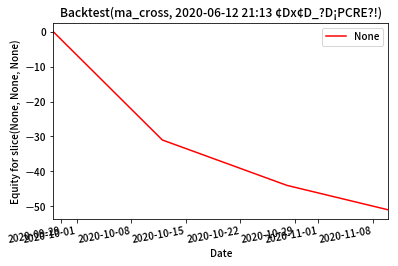

In [18]:
bt.plot_equity()
plt.xticks(rotation=10)

(array([737666., 737669., 737683., 737697., 737699., 737713., 737727.,
        737730., 737744., 737758., 737760.]),
 <a list of 11 Text xticklabel objects>)

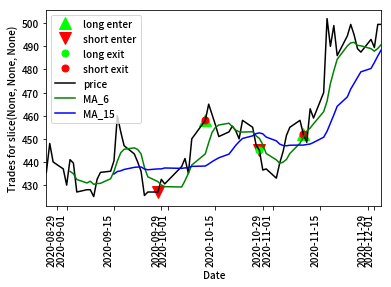

In [22]:
short_ma = 6
long_ma = 15
bt.plot_trades()
ohlc.C.rolling(short_ma).mean().plot(c = 'green', label = 'MA_6')
ohlc.C.rolling(long_ma).mean().plot(c ='blue', label = 'MA_15')
plt.legend(loc = 'upper left')
plt.xticks(rotation=90)